In [1]:
# Clustering features - playground to see correlations between different features, etc.


In [2]:
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import torch
print(torch.cuda.is_available())  # in case needed

True


In [3]:
path = "/afs/cern.ch/work/g/gkrzmanc/mlpf_results/cluster_features/cluster_features"
r = {}
for file in os.listdir(path):
    f = pickle.load(open(os.path.join(path, file), "rb"))
    for key in f:
        if key not in r:
            r[key] = f[key]
        else:
            r[key] = torch.concatenate((r[key], f[key]), axis=0)

In [4]:
x_names = ["ecal_E", "hcal_E", "num_hits", "track_p", "ecal_dispersion", "hcal_dispersion", "sum_e", "num_tracks"]


In [5]:
r.keys()

dict_keys(['x', 'e_true', 'e_reco', 'true_e_corr'])

In [6]:
data = {}
for i, key in enumerate(x_names):
    data[key] = r["x"][:, i].cpu().numpy()

data["e_true"] = r["e_true"].cpu().numpy()
data["true_e_corr"] = r["true_e_corr"].cpu().numpy()

data.keys()

dict_keys(['ecal_E', 'hcal_E', 'num_hits', 'track_p', 'ecal_dispersion', 'hcal_dispersion', 'sum_e', 'num_tracks', 'e_true', 'true_e_corr'])

In [7]:
len(data["ecal_E"])

22313

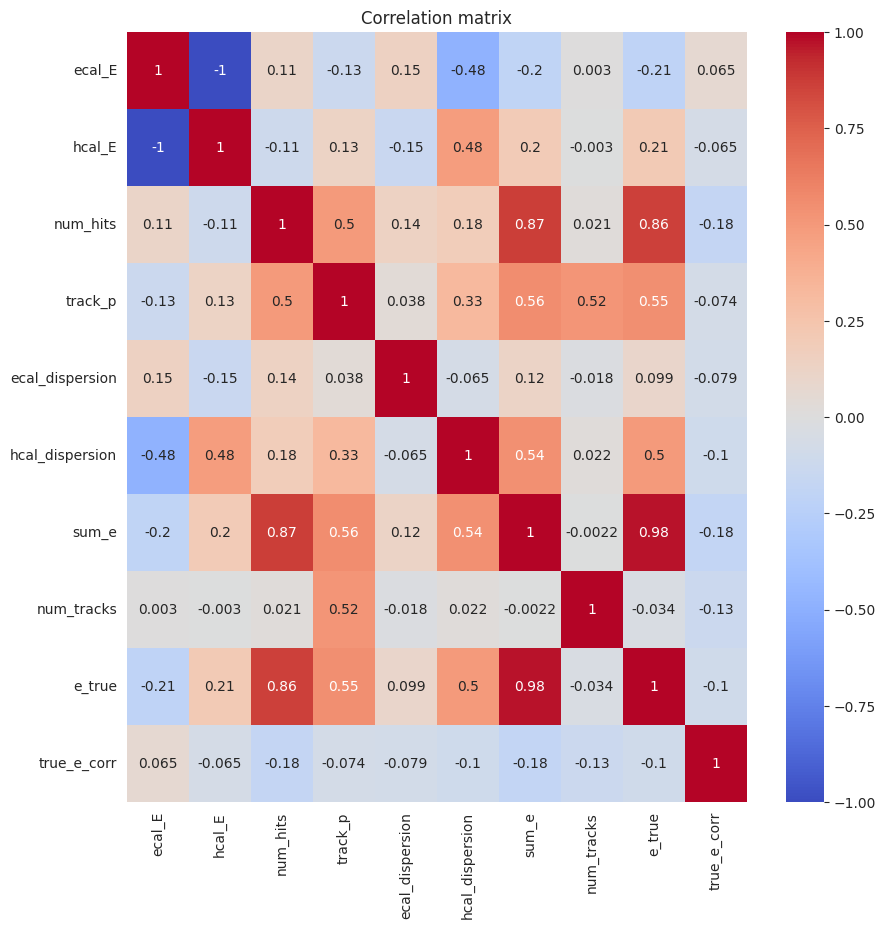

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
# data corr matrix
data_corr = pd.DataFrame(data).corr()
# plot the heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(data_corr, annot=True, cmap='coolwarm', cbar=True)
plt.title('Correlation matrix')
plt.show()


In [9]:
# small histograms for these features
fig, ax = plt.subplots(10, figsize=(5, 12))
for i, key in enumerate(data.keys()):
    ax[i].hist(data[key], bins=100)
    ax[i].set_title(key)

fig.tight_layout()
fig.show()

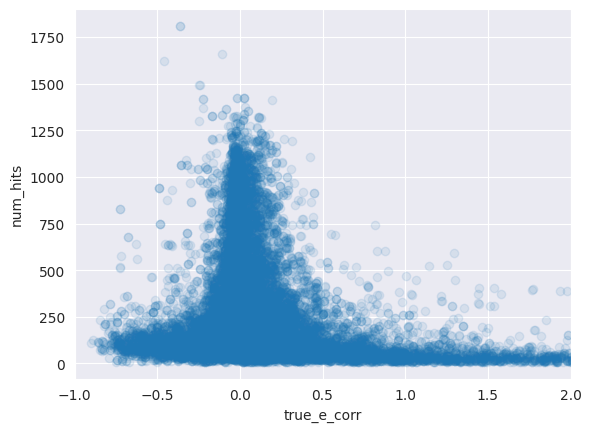

In [13]:
# scatterplot of data["true_e_corr_factor"] and data["num_hits"]
plt.scatter(data["true_e_corr"], data["num_hits"], alpha=0.1)
plt.xlabel("true_e_corr")
plt.xlim([-1, 2])
plt.ylabel("num_hits")
plt.show()


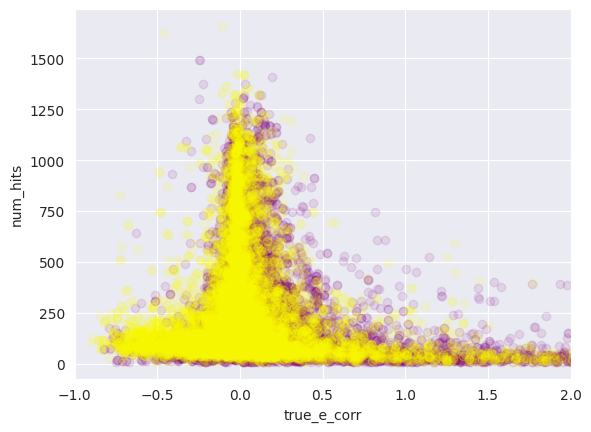

In [14]:
# scatterplot of data["true_e_corr_factor"] and data["num_hits"]
no_tracks_idx = data["num_tracks"] == 0
tracks_idx = data["num_tracks"] == 1

# the same code as below but with no_tracks_idx

plt.scatter(data["true_e_corr"][no_tracks_idx], data["num_hits"][no_tracks_idx], alpha=0.1, color="purple")
plt.scatter(data["true_e_corr"][tracks_idx], data["num_hits"][tracks_idx], alpha=0.1, color="yellow")
plt.xlabel("true_e_corr")
plt.xlim([-1, 2])
plt.ylabel("num_hits")
plt.show()


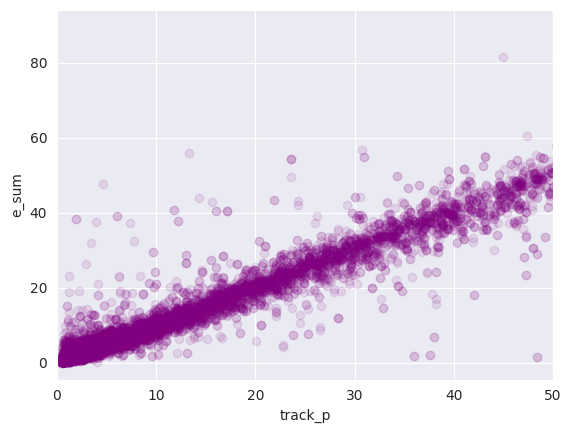

In [15]:
# scatterplot of data["true_e_corr_factor"] and data["num_hits"]
tracks_idx = data["num_tracks"] == 1
# the same code as below but with no_tracks_idx

plt.scatter(data["track_p"][tracks_idx], data["sum_e"][tracks_idx], alpha=0.1, color="purple")
#plt.scatter(data["true_e_corr"][tracks_idx], data["track_p"][tracks_idx], alpha=0.1)
#plt.xlabel("true_e_corr")
plt.xlabel("track_p")
plt.ylabel("e_sum")
plt.xlim([0, 50])

plt.show()
#plt.ylabel("track p")
#plt.show()


In [ ]:
# scatterplot of data["true_e_corr_factor"] and data["num_hits"]
# the same code as below but with no_tracks_idx

#plt.scatter(data["hcal_E"], data["true_e_corr"], alpha=0.1, color="purple")
plt.scatter(data["ecal_E"], data["true_e_corr"], alpha=0.1, color="yellow")

#plt.scatter(data["true_e_corr"][tracks_idx], data["track_p"][tracks_idx], alpha=0.1)
#plt.xlabel("true_e_corr")
plt.xlabel("ecal E percentage (yellow)")
plt.ylabel("true E corr factor")
plt.xlim([0, 1])
plt.ylim([-2, 5.0])
plt.show()


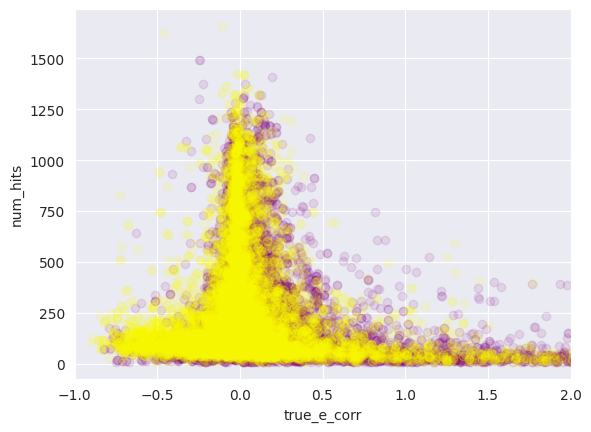

In [17]:
plt.scatter(data["true_e_corr"][no_tracks_idx], data["num_hits"][no_tracks_idx], alpha=0.1, color="purple")
plt.scatter(data["true_e_corr"][tracks_idx], data["num_hits"][tracks_idx], alpha=0.1, color="yellow")
plt.xlabel("true_e_corr")
plt.xlim([-1, 2])
plt.ylabel("num_hits")
plt.show()



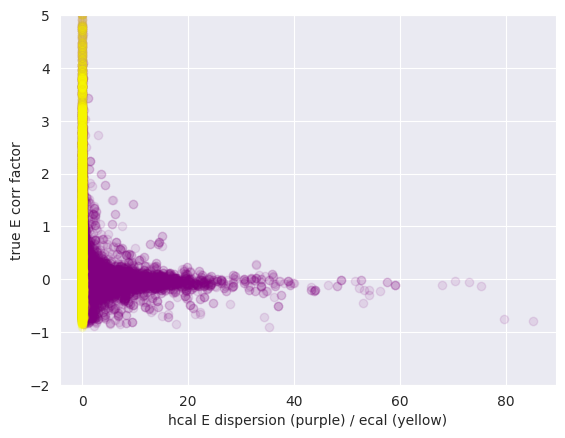

In [18]:
# scatterplot of data["true_e_corr_factor"] and data["num_hits"]
# the same code as below but with no_tracks_idx

plt.scatter(data["hcal_dispersion"], data["true_e_corr"], alpha=0.1, color="purple")
plt.scatter(data["ecal_dispersion"], data["true_e_corr"], alpha=0.1, color="yellow")

#plt.scatter(data["true_e_corr"][tracks_idx], data["track_p"][tracks_idx], alpha=0.1)
#plt.xlabel("true_e_corr")
plt.xlabel("hcal E dispersion (purple) / ecal (yellow)")
plt.ylabel("true E corr factor")
#plt.xlim([0, 1])
plt.ylim([-2, 5.0])
plt.show()


In [10]:
# regress using a simple NN r["true_e_corr"] using r["x"]
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np

In [20]:

# split the data
x = r["x"].cpu().numpy()
print(x.shape)
y = r["true_e_corr"].cpu().numpy()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


(22313, 8)


In [21]:

# create a simple NN
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # add batchnorm
        
        self.nn = nn.ModuleList([
            nn.BatchNorm1d(8),
            nn.Linear(8, 16),
            nn.LeakyReLU(negative_slope=0.2),
            nn.BatchNorm1d(16),
            nn.Linear(16, 16),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Linear(16,16),
            nn.BatchNorm1d(16),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Linear(16, 1)
        ])
            
            
    def forward(self, x):
        for module in self.nn:
            x = module(x)
        return x
    

In [21]:
# create a dataset and a dataloader
train_dataset = TensorDataset(torch.tensor(x_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(x_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [22]:
# create a model, loss function and optimizer
model = Net()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)

cuda:0


In [23]:
# train the model
n_epochs = 100
for epoch in range(n_epochs):
    model.train()
    for x, y in train_loader:
        optimizer.zero_grad()
        x, y = x.to(device), y.to(device)
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {loss.item()}")

/home/gkrzmanc/env/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/gkrzmanc/env/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/100, Loss: 62.82325744628906
Epoch 2/100, Loss: 2.5911951065063477
Epoch 3/100, Loss: 26.61960792541504
Epoch 4/100, Loss: 8.934041976928711
Epoch 5/100, Loss: 282.7839050292969
Epoch 6/100, Loss: 3.4426350593566895
Epoch 7/100, Loss: 0.8984308242797852
Epoch 8/100, Loss: 0.4561064541339874
Epoch 9/100, Loss: 2.838141918182373
Epoch 10/100, Loss: 1.4578570127487183
Epoch 11/100, Loss: 0.908459484577179
Epoch 12/100, Loss: 265.0960388183594
Epoch 13/100, Loss: 0.6715747117996216
Epoch 14/100, Loss: 236.1400604248047
Epoch 15/100, Loss: 0.23673370480537415
Epoch 16/100, Loss: 0.9374264478683472
Epoch 17/100, Loss: 0.4644523859024048
Epoch 18/100, Loss: 0.7723300457000732
Epoch 19/100, Loss: 1.4324326515197754
Epoch 20/100, Loss: 0.44936472177505493
Epoch 21/100, Loss: 0.7294731140136719
Epoch 22/100, Loss: 547.9168701171875
Epoch 23/100, Loss: 0.5601940751075745
Epoch 24/100, Loss: 0.3553294837474823
Epoch 25/100, Loss: 0.8890964984893799
Epoch 26/100, Loss: 0.3631521761417389
Ep

In [24]:
# eval the model
model.eval()
with torch.no_grad():
    # move to device
    x_test, y_test = torch.tensor(x_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)
    x_test, y_test = x_test.to(device), y_test.to(device)
    y_pred = model(torch.tensor(x_test, dtype=torch.float32))
    loss = criterion(y_pred, torch.tensor(y_test, dtype=torch.float32))
    print(f"Loss: {loss.item()}")


Loss: 22.786191940307617


/tmp/gkrzmanc/ipykernel_32521/3268894561.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model(torch.tensor(x_test, dtype=torch.float32))
/tmp/gkrzmanc/ipykernel_32521/3268894561.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(y_pred, torch.tensor(y_test, dtype=torch.float32))
/home/gkrzmanc/env/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([24214])) that is different to the input size (torch.Size([24214, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


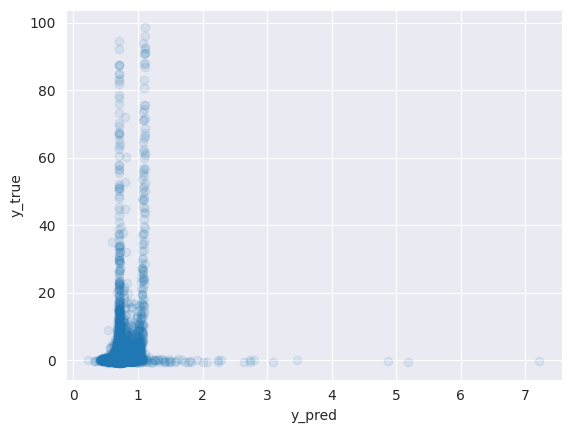

In [25]:
# scatterplot y_pred and y_test
plt.scatter(y_pred.detach().cpu(), y_test.detach().cpu(), alpha=0.1)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

tracks+hits 0.7823088258613878
tracks 0.7056900048691802
hits 0.6875172123042903


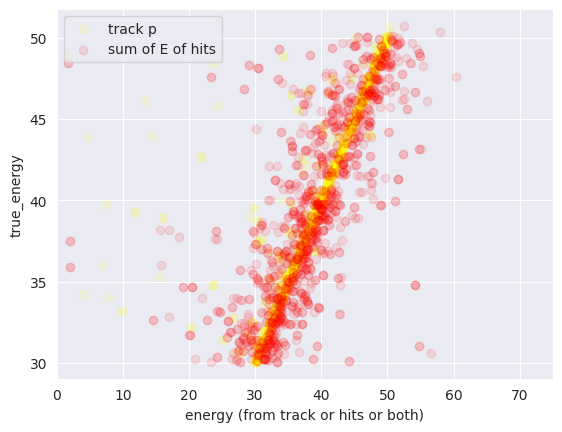

In [11]:
# scatterplot of data["true_e_corr_factor"] and data["num_hits"]
tracks_idx = (data["num_tracks"] == 1) & (data["e_true"] > 30)
# the same code as below but with no_tracks_idx

avg_energy = (data["sum_e"][tracks_idx] + data["track_p"][tracks_idx]) / 2
track_p_energy = data["track_p"][tracks_idx]
true_energy = data["e_true"][tracks_idx]
# correl. coeff.
print("tracks+hits", np.corrcoef(avg_energy, true_energy)[0,1])
print("tracks", np.corrcoef(track_p_energy, true_energy)[0,1])
print("hits", np.corrcoef(data["sum_e"][tracks_idx], true_energy)[0,1])

# now do a scatterplot of those
#plt.scatter(avg_energy, true_energy, alpha=0.1, color="purple")
plt.scatter(track_p_energy, true_energy, alpha=0.1, color="yellow", label="track p")
plt.scatter(data["sum_e"][tracks_idx], true_energy, alpha=0.1, color="red", label="sum of E of hits")
plt.legend()
plt.xlabel("energy (from track or hits or both)")
plt.ylabel("true_energy")
plt.xlim([0, 75])
plt.show()


tracks+hits 0.9572582260050095
tracks 0.9359735248146835
hits 0.9069358724068058


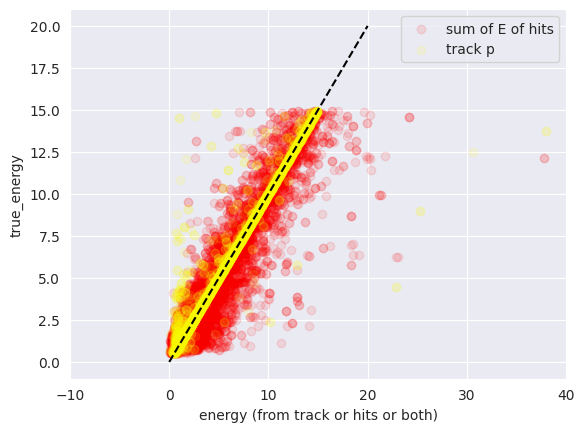

In [15]:
# scatterplot of data["true_e_corr_factor"] and data["num_hits"]
tracks_idx = (data["num_tracks"] == 1) & (data["e_true"] < 15)
# the same code as below but with no_tracks_idx

avg_energy = (data["sum_e"][tracks_idx] + data["track_p"][tracks_idx]) / 2
track_p_energy = data["track_p"][tracks_idx]
true_energy = data["e_true"][tracks_idx]
# correl. coeff.
print("tracks+hits", np.corrcoef(avg_energy, true_energy)[0,1])
print("tracks", np.corrcoef(track_p_energy, true_energy)[0,1])
print("hits", np.corrcoef(data["sum_e"][tracks_idx], true_energy)[0,1])

# now do a scatterplot of those
#plt.scatter(avg_energy, true_energy, alpha=0.1, color="purple")

plt.scatter(data["sum_e"][tracks_idx], true_energy, alpha=0.1, color="red", label="sum of E of hits")
plt.scatter(track_p_energy, true_energy, alpha=0.1, color="yellow", label="track p")
# draw an "identity" dashed line from 0 to 20
plt.plot([0, 20], [0, 20], "k--")
plt.legend()
plt.xlabel("energy (from track or hits or both)")
plt.ylabel("true_energy")
plt.xlim([-10, 40])
plt.show()


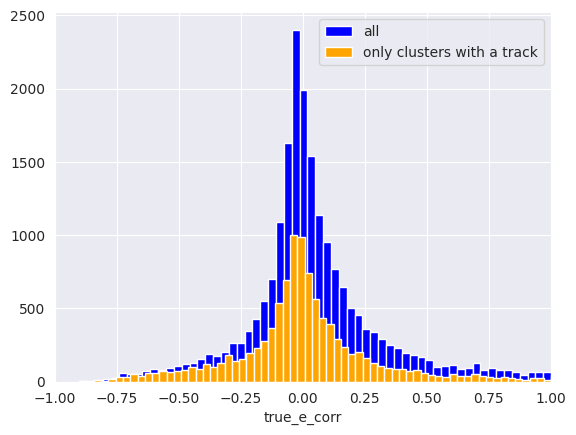

In [23]:
# distribution of energy corr factor
plt.hist(data["true_e_corr"], bins=1000, color="blue", label="all")
plt.hist(data["true_e_corr"][data["num_tracks"] == 1], bins=1000, color="orange", label="only clusters with a track")
plt.xlabel("true_e_corr")
plt.xlim([-1,1])
plt.legend()
plt.show()

In [198]:
#  Model just for energy regression + weighted loss based on energy #
# create a model, loss function and optimizer
model = Net()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)
# train the model
n_epochs = 100
for epoch in range(n_epochs):
    model.train()
    for x, y in train_loader:
        optimizer.zero_grad()
        x, y = x.to(device), y.to(device)
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {loss.item()}")
# eval the model
model.eval()
with torch.no_grad():
    # move to device
    x_test, y_test = torch.tensor(x_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)
    x_test, y_test = x_test.to(device), y_test.to(device)
    y_pred = model(torch.tensor(x_test, dtype=torch.float32))
    loss = criterion(y_pred, torch.tensor(y_test, dtype=torch.float32))
    print(f"Loss: {loss.item()}")

# scatterplot y_pred and y_test
plt.scatter(y_pred.detach().cpu(), y_test.detach().cpu(), alpha=0.1)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()
# scatterplot of data["true_e_corr_factor"] and data["num_hits"]
tracks_idx = data["num_tracks"] == 1
# the same code as below but with no_tracks_idx

avg_energy = (data["sum_e"][tracks_idx] + data["track_p"][tracks_idx]) / 2
track_p_energy = data["track_p"][tracks_idx]
true_energy = data["e_true"][tracks_idx]
# correl. coeff.
print("tracks+hits", np.corrcoef(avg_energy, true_energy)[0, 1])
print("tracks", np.corrcoef(track_p_energy, true_energy)[0, 1])
print("hits", np.corrcoef(data["sum_e"][tracks_idx], true_energy)[0, 1])
# now do a scatterplot of those
plt.scatter(avg_energy, true_energy, alpha=0.1, color="purple")
plt.scatter(track_p_energy, true_energy, alpha=0.1, color="yellow")
plt.scatter(data["sum_e"][tracks_idx], true_energy, alpha=0.1, color="green")
plt.xlabel("energy (from track or hits or both)")
plt.ylabel("true_energy")
plt.show()

cuda:0
Epoch 1/100, Loss: 0.8779515027999878
Epoch 2/100, Loss: 3.501530170440674
Epoch 3/100, Loss: 1.4194138050079346
Epoch 4/100, Loss: 0.5639323592185974
Epoch 5/100, Loss: 0.0684133917093277
Epoch 6/100, Loss: 0.6226361393928528


KeyboardInterrupt: 